In [3]:
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# The Goal

The goal of this model is to create a simple intent classfication model so that people can ask a chatbot a question and the bot attempts to decide which topic the user is interested in.

# The Data

The data consists of 437 manually collect and labeled questions about wildfires. These questions are sourced from places like Reddit, Quora, Answers, Facebook, and Twitter. The desire was to have data that reflected topics of interest on the internet as well as the particular phrasing that users might use when talking to the chat bot.

Each question includes the text label and one of 5 large categories that it could belong to:

1. Fire Ecology
2. Fire Preparation
3. Emergency Protocols
4. Fire Recovery
5. Getting Involved



In [4]:
df = pd.read_csv("data/intent-classification-training-data.csv").loc[:,["Question","Large Category"]]
display(df.sample(5))
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

,Question,Large Category
138,What caused the wildfire in California in so m...,Fire Ecology
198,Where is the nearest fire?,Fire Ecology
289,Insurance for wildfires?,Fire Preparation
262,What can be done by the government in Californ...,Fire Preparation
235,How do you prepare for a fire?,Fire Preparation


# The Model

The model uses spacy and their English web language model to vectorize the question. That vector is then passed into a classifier.

We tried quite a few models including, but not limited to:

1. Support Vector Classifier + PCA with various hyperparameter tuning.
2. Linear Regression + PCA with various hyperparameter tuning.
3. Linear Regression with different solvers to aid in convergence.
4. Random Forest with various hyperparameter tuning.

Ultimately, despite our attempts to use a more complex model, it did not help. A simple logistic regression yielded the best results. The model doesn't have much data to learn from, so the correct classification rates did suffer. Our hope is to collect data as the bot is in use and further use that data to train the model.

In [9]:
class TextVectorizer(TransformerMixin):
    
    def transform(self, X, **transform_params):
        nlp = spacy.load(r'data/en_core_web_md-3.0.0')
        new_X = np.zeros((len(X), nlp.vocab.vectors_length))
        # Iterate over the sentences
        for idx, sentence in enumerate(X):
            # Pass each sentence to the nlp object to create a document
            doc = nlp(sentence)
            # Save the document's .vector attribute to the corresponding row in     
            # X
            new_X[idx, :] = doc.vector
        return new_X
    
    def fit(self, X, y=None, **fit_params):
        return self

In [10]:
pipe = Pipeline([
    ("Spacy_Vectorizer", TextVectorizer()),
    ('Classifier',  LogisticRegression(solver='lbfgs', max_iter=7600))
])

In [11]:
pipe.fit(df_train["Question"], df_train["Large Category"])

Pipeline(steps=[('Spacy_Vectorizer',
                 <__main__.TextVectorizer object at 0x00000284112B81F0>),
                ('Classifier', LogisticRegression(max_iter=7600))])

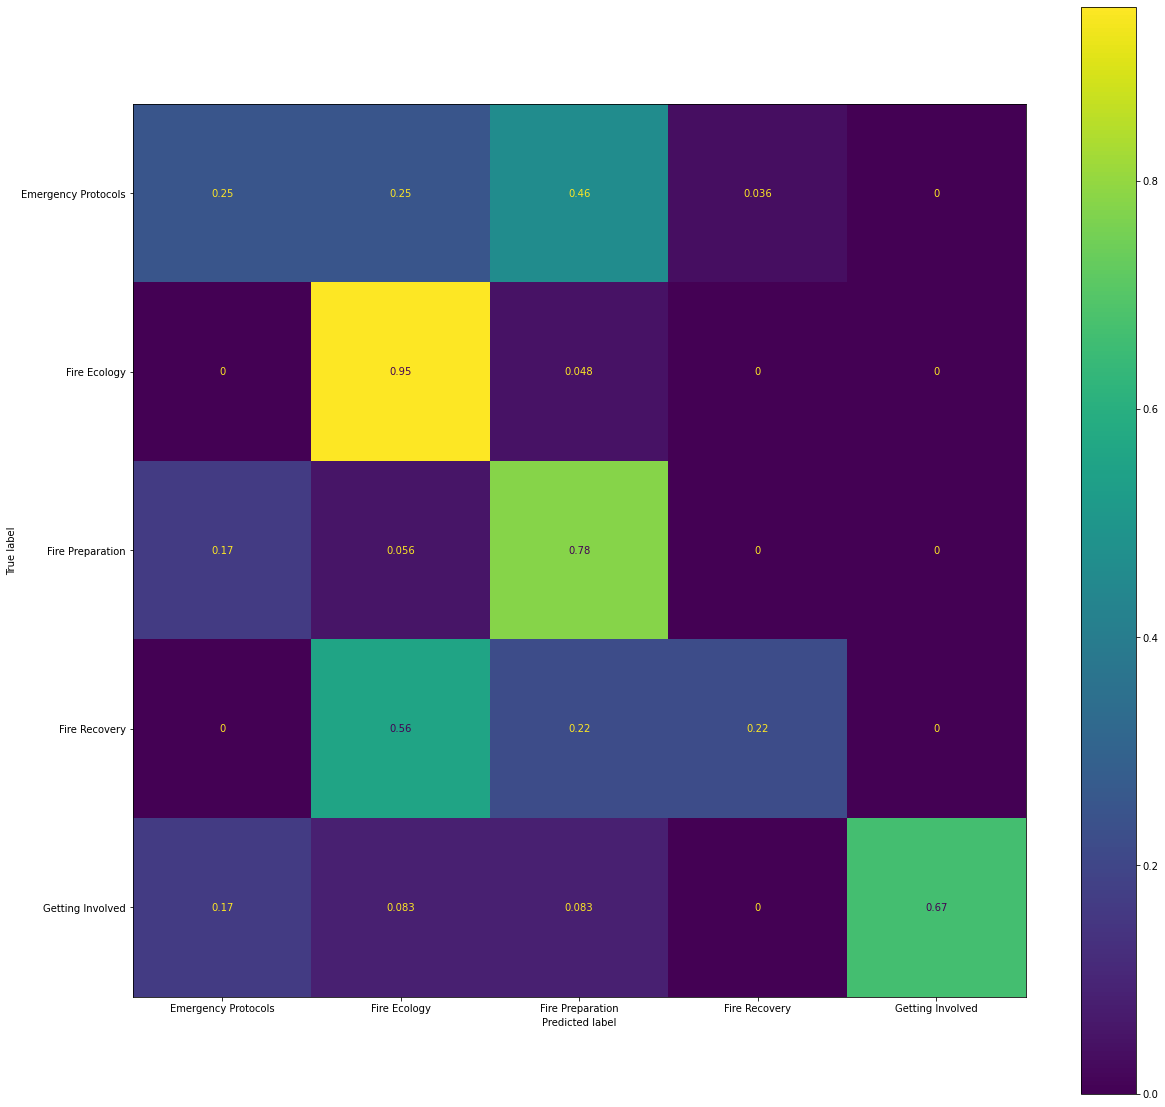

In [40]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(pipe, df_test.Question, df_test["Large Category"], normalize='true', ax=ax);

In [25]:
scores = cross_val_score(pipe, X=df_train.Question, y=df_train["Large Category"], cv=5)

In [26]:
scores

array([0.81428571, 0.68571429, 0.77142857, 0.7       , 0.68115942])

In [43]:
with open(r"data/model.sav", "wb") as outfile:
    pickle.dump(pipe, outfile)